In [42]:
import csv
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import torch.optim as optim
from torch import nn 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Importing

In [43]:
data = []

with open('almonds/Almond.csv', 'r') as dataset:
    reader = csv.reader(dataset)

    headers = [re.sub(r'\s*\(.*\)','',header).strip() for header in next(reader)[1:]]
    types = []

    for line in reader:
        row = {}
        for x, value in enumerate(line[1:]):
            if x < len(headers) - 1:
                row[headers[x]] = float(value) if value != '' else None
            else:
                if value not in types:
                    types.append(value)
                row[headers[x]] = types.index(value) if value != '' else None
        data.append(row)

### Preprocessing

In [44]:
nones = defaultdict(int)

for instance in data:
    for feature, value in instance.items():
        if value == None:
            nones[feature] += 1

lengths = [instance['Length'] for instance in data]
widths = [instance['Width'] for instance in data]
thicknesses = [instance['Thickness'] for instance in data]

ratios = [instance['Length'] / instance['Width'] for instance in data if instance['Length'] is not None and instance['Width'] is not None]
median_ratio = np.median(ratios)

thickness_median = np.median([value for value in thicknesses if value is not None])

for instance in data:
    if instance['Length'] is None:
        instance['Length'] = instance['Width'] * median_ratio      
    elif instance['Width'] is None:
        instance['Width'] = instance['Length'] / median_ratio
    elif instance['Thickness'] is None:
        instance['Thickness'] = thickness_median
        
    if instance['Roundness'] is None: 
        instance['Roundness'] = 4 * instance['Area'] / (np.pi * instance['Length'] ** 2)
    if instance['Aspect Ratio'] is None: 
        instance['Aspect Ratio'] = instance['Length'] / instance['Width']
    if instance['Eccentricity'] is None:
        instance['Eccentricity'] = np.sqrt(1 - (instance['Width'] / instance['Length'])**2)


### Setup and Execution of NN for Hyperparameter Optimisation

Learning rate: 0.001, Hidden units: 64
Accuracy: 64.93% and STD: 0.02
Learning rate: 0.001, Hidden units: 96
Accuracy: 69.82% and STD: 0.03
Learning rate: 0.001, Hidden units: 128
Accuracy: 71.81% and STD: 0.02
Learning rate: 0.001, Hidden units: 160
Accuracy: 72.73% and STD: 0.01
Learning rate: 0.001, Hidden units: 192
Accuracy: 73.75% and STD: 0.01
Learning rate: 0.001, Hidden units: 224
Accuracy: 74.52% and STD: 0.01
Learning rate: 0.001, Hidden units: 256
Accuracy: 74.52% and STD: 0.01
Learning rate: 0.001, Hidden units: 288
Accuracy: 75.64% and STD: 0.01
Learning rate: 0.001, Hidden units: 320
Accuracy: 76.60% and STD: 0.01
Learning rate: 0.001, Hidden units: 352
Accuracy: 76.20% and STD: 0.01
Learning rate: 0.001, Hidden units: 384
Accuracy: 76.76% and STD: 0.01
Learning rate: 0.001, Hidden units: 416
Accuracy: 77.32% and STD: 0.01
Learning rate: 0.001, Hidden units: 448
Accuracy: 77.32% and STD: 0.01
Learning rate: 0.001, Hidden units: 480
Accuracy: 77.16% and STD: 0.01
Learning

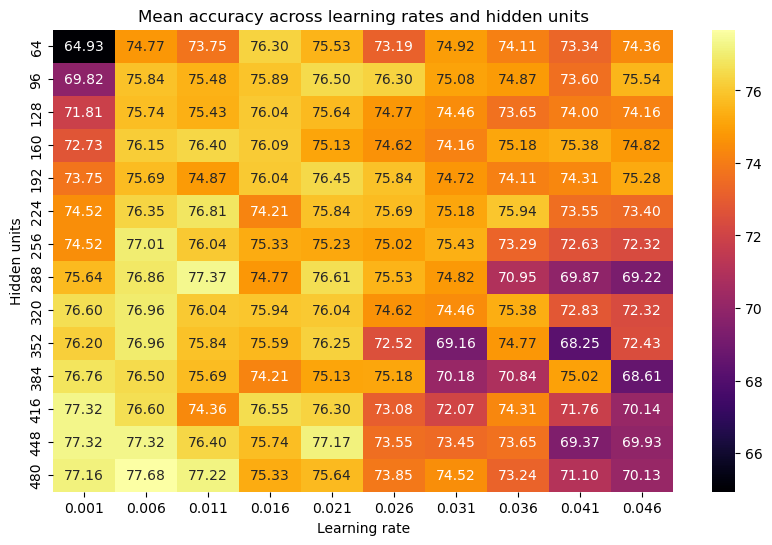

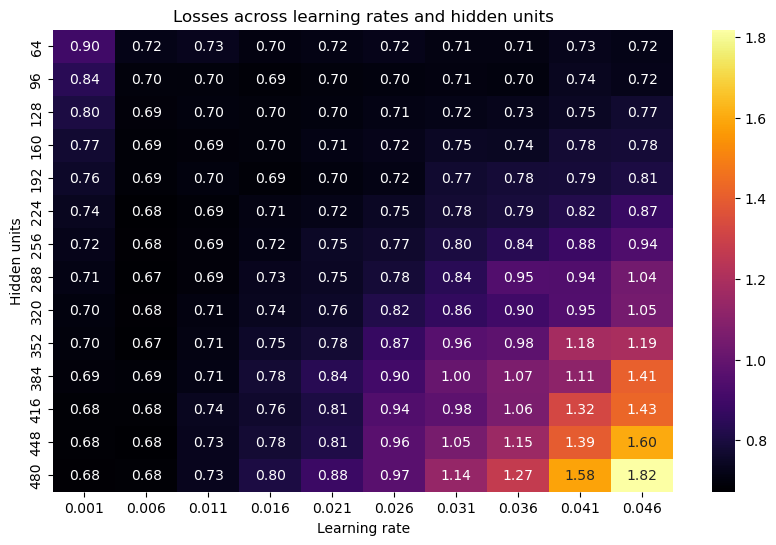

Test accuracy: 80.52%
Precision: 0.80
Recall: 0.80
F1: 0.80
Test loss: 0.5824


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = headers[:-1]
target = headers[-1]

X = [[instance[feature] for feature in features] for instance in data]
y = [instance[target] for instance in data]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=97)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=97)

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.cpu()), dtype=torch.float32).to(device)
X_val = torch.tensor(scaler.transform(X_val.cpu()), dtype=torch.float32).to(device)
X_test = torch.tensor(scaler.transform(X_test.cpu()), dtype=torch.float32).to(device)

class AlmondNN(nn.Module): #consider batch normalisation and different activation functions and dropout layers
    def __init__(self, hidden_units):
        super(AlmondNN, self).__init__()
        self.fc1 = nn.Linear(len(features), hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.fc3 = nn.Linear(hidden_units // 2, hidden_units // 4)
        self.fc4 = nn.Linear(hidden_units // 4, len(types))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x 
    
lrs = np.arange(0.001, 0.05, 0.005)
hidden_range = np.arange(64, 512, 32)
epochs = 100

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=97)

highest_mean_acc, lowest_std_acc = 0, float('inf') 
lowest_loss = float('inf')
acc_lr, acc_h, std_lr, std_h = None, None, None, None

for lr, hidden in itertools.product(lrs, hidden_range):
    lr = round(lr, 4)
    accuracies = []
    train_losses = []
    val_losses = []
    print(f'Learning rate: {lr}, Hidden units: {hidden}')
    criterion = nn.CrossEntropyLoss()

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        model = AlmondNN(hidden).to(device)
        optimiser = optim.Adam(model.parameters(), lr=lr)

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        best_val_loss = float('inf')
        best_accuracy = 0
        patience_count = 0
        patience = 10

        fold_train_losses = []
        fold_val_losses = []

        for epoch in range(epochs):
            model.train()
            optimiser.zero_grad()

            outputs = model(X_train_fold)
            train_loss = criterion(outputs, y_train_fold)
            train_loss.backward()
            optimiser.step()

            fold_train_losses.append(train_loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_val_fold)
                val_loss = criterion(outputs, y_val_fold)
                _, predicted = torch.max(outputs, 1)

                accuracy = (predicted == y_val_fold).sum().item() / len(y_val_fold)

            fold_val_losses.append(val_loss.item())

            if accuracy > best_accuracy:
                best_accuracy = accuracy

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_count = 0
            else:
                patience_count += 1

            if patience_count >= patience:
                break

        accuracies.append(best_accuracy)
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)
    
    accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    loss = np.mean(np.concatenate(val_losses))

    if accuracy > highest_mean_acc:
        highest_mean_acc = accuracy
        acc_lr, acc_h = lr, hidden
    if std_accuracy < lowest_std_acc:
        lowest_std_acc = std_accuracy
        std_lr, std_h = lr, hidden

    if loss < lowest_loss:
        lowest_loss = loss
        loss_lr, loss_h = lr, hidden

    results.append({
        'lr': lr,
        'epochs': epochs,
        'hidden units': hidden,
        'mean accuracy': accuracy * 100,
        'mean loss': loss,
        'standard dev accuracy' : std_accuracy
    })

print(f'Best validation accuracy {highest_mean_acc * 100:.2f} with learning rate of {acc_lr} and hidden units of {acc_h}')
print(f'Best std {lowest_std_acc:.2f} with learning rate of {std_lr} and hidden units of {std_h}')
print(f'Best loss {lowest_loss} with learning rate of {loss_lr} and hidden units of {loss_h}')

results = pd.DataFrame(results)

pivot_mean = results.pivot_table(index='hidden units', columns='lr', values='mean accuracy')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_mean, annot=True, cmap='inferno', fmt='.2f')
plt.title('Mean accuracy across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

pivot_std = results.pivot_table(index='hidden units', columns='lr', values='mean loss')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_std, annot=True, cmap='inferno', fmt='.2f')
plt.title('Losses across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

model = AlmondNN(acc_h).to(device)
optimiser = optim.Adam(model.parameters(), lr=acc_lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    optimiser.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimiser.step()

model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
print(f'Recall: {recall_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
print(f'F1: {f1_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
test_loss = criterion(outputs, y_test).item()
print(f'Test loss: {test_loss:.4f}')

### Training Algorithm comparison

rprop Test Loss: 0.6943, Test Accuracy: 80.9976
rprop Test Loss: 0.9998, Test Accuracy: 40.6176
rprop Test Loss: 0.9790, Test Accuracy: 46.3183
rprop Test Loss: 0.9878, Test Accuracy: 49.1686
rprop Test Loss: 0.9798, Test Accuracy: 48.2185
adamw Test Loss: 0.6059, Test Accuracy: 77.6722
adamw Test Loss: 1.0094, Test Accuracy: 44.1805
adamw Test Loss: 0.9764, Test Accuracy: 46.5558
adamw Test Loss: 0.9923, Test Accuracy: 43.9430
adamw Test Loss: 0.9970, Test Accuracy: 46.5558


C:\Users\wiand\AppData\Local\Temp\ipykernel_33440\1453684176.py:88: RuntimeWarning: Mean of empty slice
  adamw_train_mean = np.nanmean(adamw_train_losses, axis=0)
c:\Users\wiand\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\wiand\AppData\Local\Temp\ipykernel_33440\1453684176.py:90: RuntimeWarning: Mean of empty slice
  adamw_val_mean = np.nanmean(adamw_val_losses, axis=0)


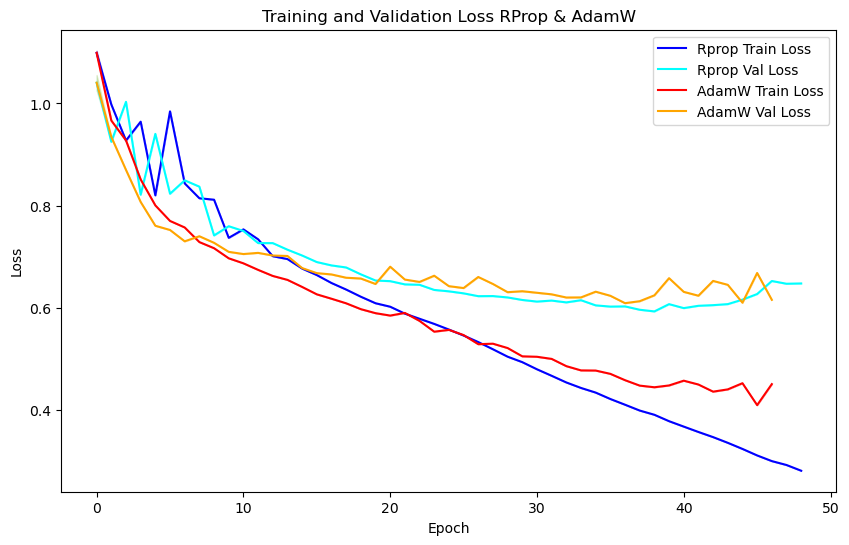

In [46]:
comparison_results = {
    'rprop': {
        'train_losses': [],
        'val_losses': []
    },
    'adamw': {
        'train_losses': [],
        'val_losses': []
    }
}

for optimiser_name in ['rprop', 'adamw']:
    runs = 5
    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for run in range(runs):
        model = AlmondNN(acc_h).to(device)
        optimiser = optim.Rprop(model.parameters(), lr=acc_lr) if optimiser_name == 'rprop' else optim.AdamW(model.parameters(), lr=acc_lr)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_losses = []        

        for epoch in range(epochs):
            model.train()
            optimiser.zero_grad()

            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimiser.step()

            train_losses.append(loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_val)
                val_loss = criterion(outputs, y_val)
                _, predicted = torch.max(outputs, 1)
                val_losses.append(val_loss.item())

                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    counter = 0
                else:
                    counter += 1

                if counter >= patience:
                    break    
        
        comparison_results[optimiser_name]['train_losses'].append(train_losses)
        comparison_results[optimiser_name]['val_losses'].append(val_losses)

        model.eval()

        with torch.no_grad():
            outputs = model(X_test)
            test_loss = criterion(outputs, y_test).item()
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / len(y_test)

        print(f'{optimiser_name} Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.4f}')

max_len = max(max(len(losses) for losses in comparison_results[opt]['train_losses']) for opt in comparison_results)

def pad_with_nan(arr, max_len):
    padded = []

    for vals in arr:
        if len(vals) < max_len:
            vals = np.concatenate([vals, [np.nan] * (max_len - len(vals))])
        padded.append(vals)

    return np.array(padded)

rprop_train_losses = pad_with_nan(comparison_results['rprop']['train_losses'], max_len)
rprop_val_losses = pad_with_nan(comparison_results['rprop']['val_losses'], max_len)
adamw_train_losses = pad_with_nan(comparison_results['adamw']['train_losses'], max_len)
adamw_val_losses = pad_with_nan(comparison_results['adamw']['val_losses'], max_len)

rprop_train_mean = np.nanmean(rprop_train_losses, axis=0)
rprop_train_std = np.nanstd(rprop_train_losses, axis=0)
rprop_val_mean = np.nanmean(rprop_val_losses, axis=0)
rprop_val_std = np.nanstd(rprop_val_losses, axis=0)
adamw_train_mean = np.nanmean(adamw_train_losses, axis=0)
adamw_train_std = np.nanstd(adamw_train_losses, axis=0)
adamw_val_mean = np.nanmean(adamw_val_losses, axis=0)
adamw_val_std = np.nanstd(adamw_val_losses, axis=0)

plt.figure(figsize=(10,6))
plt.plot(range(max_len), rprop_train_mean, label='Rprop Train Loss', color='blue')
plt.fill_between(range(max_len), rprop_train_mean - rprop_train_std, rprop_train_mean + rprop_train_std, color='blue', alpha=0.2)

plt.plot(range(max_len), rprop_val_mean, label='Rprop Val Loss', color='cyan')
plt.fill_between(range(max_len), rprop_val_mean - rprop_val_std, rprop_val_mean + rprop_val_std, color='cyan', alpha=0.2)

plt.plot(range(max_len), adamw_train_mean, label='AdamW Train Loss', color='red')
plt.fill_between(range(max_len), adamw_train_mean - adamw_train_std, adamw_train_mean + adamw_train_std, color='red', alpha=0.2)

plt.plot(range(max_len), adamw_val_mean, label='AdamW Val Loss', color='orange')
plt.fill_between(range(max_len), adamw_val_mean - adamw_val_std, adamw_val_mean + adamw_val_std, color='orange', alpha=0.2)

plt.title('Training and Validation Loss RProp & AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Hybrid Learning

Hybrid accuracy for run 0: 47.9810%
Hybrid accuracy for run 1: 59.6200%
Hybrid accuracy for run 2: 44.6556%
Hybrid accuracy for run 3: 57.9572%
Hybrid accuracy for run 4: 55.5819%


C:\Users\wiand\AppData\Local\Temp\ipykernel_33440\4193793845.py:128: RuntimeWarning: Mean of empty slice
  combined_train_losses = np.nanmean([r_train_losses_padded, a_train_losses_padded], axis=0)
C:\Users\wiand\AppData\Local\Temp\ipykernel_33440\4193793845.py:129: RuntimeWarning: Mean of empty slice
  combined_val_losses = np.nanmean([r_val_losses_padded, a_val_losses_padded], axis=0)


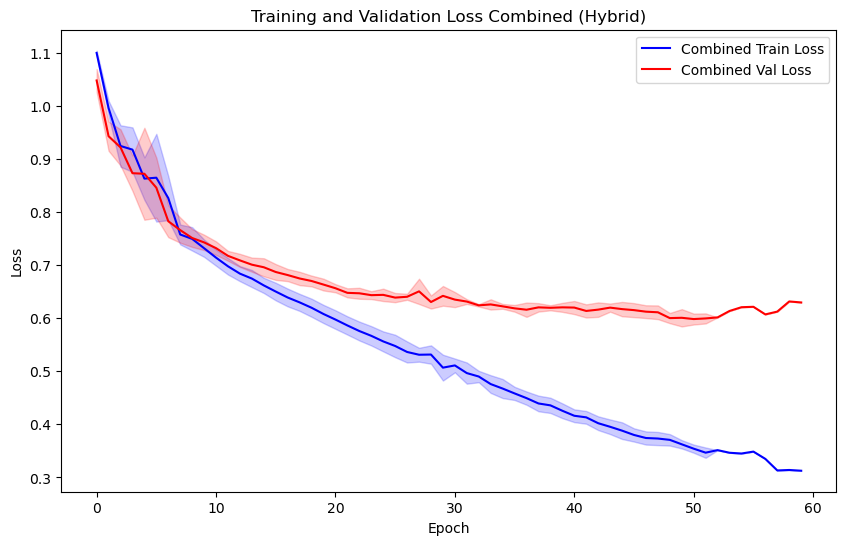

Average Hybrid Test Accuracy: 55.5819%
Average Hybrid Test Precision: 0.5387
Average Hybrid Test Recall: 0.5558
Average Hybrid Test F1 Score: 0.5329


In [47]:
r_train_losses = []
r_val_losses = []
a_train_losses = []
a_val_losses = []

runs = 5
epochs = 100
patience = 10
min_delta = 0.001

criterion = nn.CrossEntropyLoss()

for run in range(runs):
    r_model = AlmondNN(acc_h).to(device)
    a_model = AlmondNN(acc_h).to(device)

    r_optimiser = optim.Rprop(r_model.parameters(), lr=acc_lr)
    a_optimiser = optim.AdamW(a_model.parameters(), lr=acc_lr)

    r_run_train_losses = []
    r_run_val_losses = []
    a_run_train_losses = []
    a_run_val_losses = []

    accuracies = []
    recalls = []
    precisions = []
    f1s = []

    best_val_loss = float('inf')
    patience_count = 0
    prev_loss = 0

    for epoch in range(epochs):
        r_model.train()
        a_model.train()

        r_optimiser.zero_grad()
        a_optimiser.zero_grad()

        r_outputs = r_model(X_train)
        a_outputs = a_model(X_train)

        r_loss = criterion(r_outputs, y_train)
        a_loss = criterion(a_outputs, y_train)

        r_loss.backward()
        a_loss.backward()        

        r_optimiser.step()
        a_optimiser.step()

        r_run_train_losses.append(r_loss.item())
        a_run_train_losses.append(a_loss.item())

        r_model.eval()
        a_model.eval()
        with torch.no_grad():
            r_outputs = r_model(X_val)
            a_outputs = a_model(X_val)

            r_val_loss = criterion(r_outputs, y_val)
            a_val_loss = criterion(a_outputs, y_val)

            check_loss = (r_val_loss.item() + a_val_loss.item()) / 2

            r_run_val_losses.append(r_val_loss.item())
            a_run_val_losses.append(a_val_loss.item())

        if check_loss < best_val_loss - min_delta:
            best_val_loss = check_loss
            patience_count = 0
        else:
            patience_count += 1

        if patience_count >= patience:
            break

    for p1, p2 in zip(r_model.parameters(), a_model.parameters()):
        mean_weight = (p1 + p2) / 2
        p1.data = mean_weight
        p2.data = mean_weight

    r_model.eval()
    a_model.eval()
    with torch.no_grad():
        r_outputs = r_model(X_test)
        a_outputs = a_model(X_test)

        r_test_loss = criterion(r_outputs, y_test)
        a_test_loss = criterion(a_outputs, y_test)

        combined_loss = (r_test_loss.item() + a_test_loss.item()) / 2

        r_predicted = torch.argmax(r_outputs, 1)
        a_predicted = torch.argmax(a_outputs, 1)

        r_one_hot = torch.nn.functional.one_hot(r_predicted, num_classes=len(torch.unique(y_test)))
        a_one_hot = torch.nn.functional.one_hot(a_predicted, num_classes=len(torch.unique(y_test)))

        combined_probs = (r_one_hot + a_one_hot) / 2
        combined_predicted = torch.argmax(combined_probs, 1)

        hybrid_accuracy = (combined_predicted == y_test).sum().item() / len(y_test)
        hybrid_precision = precision_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')
        hybrid_recall = recall_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')
        hybrid_f1 = f1_score(y_test.cpu(), combined_predicted.cpu(), average='weighted')

        print(f"Hybrid accuracy for run {run}: {hybrid_accuracy*100:.4f}%")

        accuracies.append(hybrid_accuracy)
        recalls.append(hybrid_recall)
        precisions.append(hybrid_precision)
        f1s.append(hybrid_f1)

    r_train_losses.append(r_run_train_losses)
    r_val_losses.append(r_run_val_losses)
    a_train_losses.append(a_run_train_losses)
    a_val_losses.append(a_run_val_losses)

max_len = max(max(len(losses) for losses in r_train_losses), max(len(losses) for losses in a_train_losses))

r_train_losses_padded = pad_with_nan(r_train_losses, max_len)
r_val_losses_padded = pad_with_nan(r_val_losses, max_len)
a_train_losses_padded = pad_with_nan(a_train_losses, max_len)
a_val_losses_padded = pad_with_nan(a_val_losses, max_len)

combined_train_losses = np.nanmean([r_train_losses_padded, a_train_losses_padded], axis=0)
combined_val_losses = np.nanmean([r_val_losses_padded, a_val_losses_padded], axis=0)

combined_train_mean = np.nanmean(combined_train_losses, axis=0)
combined_train_std = np.nanstd(combined_train_losses, axis=0)
combined_val_mean = np.nanmean(combined_val_losses, axis=0)
combined_val_std = np.nanstd(combined_val_losses, axis=0)

plt.figure(figsize=(10,6))
plt.plot(range(max_len), combined_train_mean, label='Combined Train Loss', color='blue')
plt.fill_between(range(max_len), combined_train_mean - combined_train_std, combined_train_mean + combined_train_std, color='blue', alpha=0.2)

plt.plot(range(max_len), combined_val_mean, label='Combined Val Loss', color='red')
plt.fill_between(range(max_len), combined_val_mean - combined_val_std, combined_val_mean + combined_val_std, color='red', alpha=0.2)

plt.title('Training and Validation Loss Combined (Hybrid)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1s)

print(f"Average Hybrid Test Accuracy: {avg_accuracy*100:.4f}%")
print(f"Average Hybrid Test Precision: {avg_precision:.4f}")
print(f"Average Hybrid Test Recall: {avg_recall:.4f}")
print(f"Average Hybrid Test F1 Score: {avg_f1:.4f}")
